<a href="https://colab.research.google.com/github/hrshankar2002/Pytorch-notes/blob/main/pytorch_CV_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/hrshankar2002/Pytorch-notes/main/Slides/2024-02-29_08-13.png?token=GHSAT0AAAAAACNHN7LUGYWVODKZC3A2LWHGZO77WHQ">

## Computer vision libaries in PyTorch

* [`torchvision`](https://www.learnpytorch.io/03_pytorch_computer_vision/) - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Getting dataset

In [2]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]
class_name = train_data.classes
class_name, train_data.class_to_idx, train_data.targets

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9},
 tensor([9, 0, 0,  ..., 3, 0, 5]))

In [5]:
image.shape, label

(torch.Size([1, 28, 28]), 9)

# Data Visualization

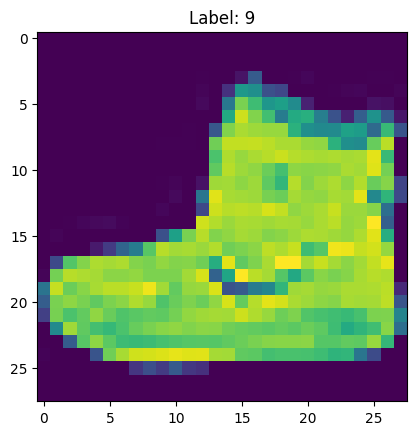

In [6]:
image, label = train_data[0]
plt.imshow(image.squeeze())
plt.title(f"Label: {label}")
plt.show()

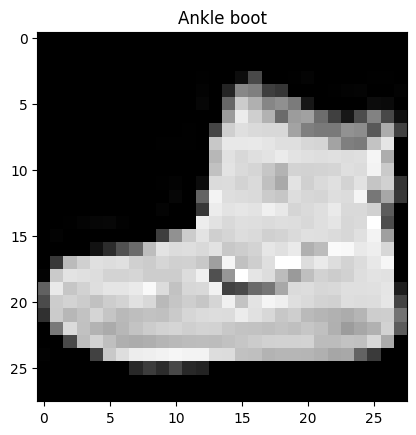

In [7]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_name[label])
plt.show()

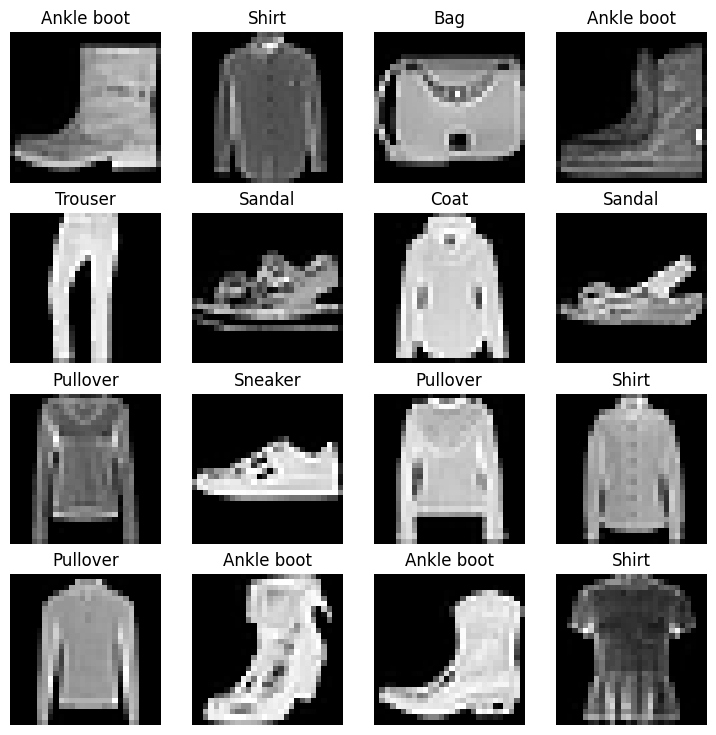

In [8]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_name[label])
  plt.axis(False);

# Prepare Dataloader

In [9]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

Right now, our data is in the form of PyTorch Datasets. DataLoader turns our dataset into a Python iterable. More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
It gives our neural network more chances to update its gradients per epoch.

In [10]:
from torch.utils.data import dataloader

BATCH_SIZE = 32

train_dataloader = dataloader.DataLoader(train_data,
                                         batch_size=BATCH_SIZE,
                                         shuffle = True
                                         )
test_dataloader = dataloader.DataLoader(test_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle = False
                                        )
train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7a35b0844df0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a368329d510>)

In [11]:
len(train_dataloader), len(test_dataloader) # 60000/32, 10000/32

(1875, 313)

In [12]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))

train_features_batch.shape, test_labels_batch.shape, len(train_features_batch)

(torch.Size([32, 1, 28, 28]), torch.Size([32]), 32)

Image size:torch.Size([1, 28, 28])
Label: 1


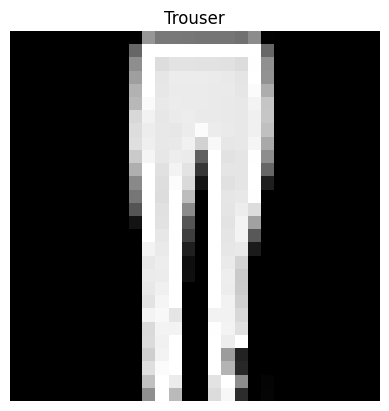

In [13]:
#torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_name[label])
plt.axis(False)
print(f"Image size:{img.shape}")
print(f"Label: {label}")

# Model building

In [14]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Input shape: {x.shape}") # [color channel, height, width]
print(f"Output shape: {output.shape}") # [color_channels, ]

Input shape: torch.Size([1, 28, 28])
Output shape: torch.Size([1, 784])


In [15]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
      super().__init__()
      self.layer_stack = nn.Sequential(
          nn.Flatten(),
          nn.Linear(input_shape, hidden_units),
          nn.Linear(hidden_units, output_shape)
      )

    def forward(self, x):
      return self.layer_stack(x)

In [16]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=28*28, # o/p of flatten layer
                              hidden_units=100,
                              output_shape=len(class_name)).to('cpu')

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [17]:
dummyx = torch.rand([1, 1, 28, 28])
model_0(dummyx)

tensor([[-0.4844,  0.2650,  0.0222,  0.2554,  0.1569,  0.1400, -0.0044, -0.0338,
          0.0068, -0.1784]], grad_fn=<AddmmBackward0>)

# Loss Optmizer & Evaluation metrics

In [18]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


In [19]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [20]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [21]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

# Training loop

In [22]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()
epochs = 5

# training and testing loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_loss = 0

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  train_loss /= len(train_dataloader)

  # Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model_0(X_test) # are of logit form

      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test,
                              y_pred=test_pred.argmax(dim=1))
      # argmax(dim=1) to convert raw logits to prdiction labels by taking the largest logit's index.
      # hence y_true & y_pred are in same formats.

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.57744 | Test loss: 0.49995, Test acc: 82.62%

Epoch: 1
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.47413 | Test loss: 0.48314, Test acc: 82.96%

Epoch: 2
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.45390 | Test loss: 0.47720, Test acc: 83.49%

Epoch: 3
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.44175 | Test loss: 0.46289, Test acc: 83.72%

Epoch: 4
---------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.

In [23]:
torch.manual_seed(42)
def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn):
  loss, acc= 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      y_pred = model(X)

      loss +=loss_fn(y_pred, y)
      acc += accuracy_fn(y, y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)
  return {
      "model_name": model.__class__.__name__,
      "model_loss": loss.item(),
      "model_acc": acc
  }

model_0_results = eval_model(model=model_0,
                          data_loader=test_dataloader,
                          loss_fn=loss_fn,
                          accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.46834293007850647,
 'model_acc': 83.18690095846645}

In [24]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Model V2 with non-linearity

In [25]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
      super().__init__()
      self.layer_stack = nn.Sequential(
          nn.Flatten(),
          nn.Linear(input_shape, hidden_units),
          nn.ReLU(),
          nn.Linear(hidden_units, output_shape),
          nn.ReLU()
      )

    def forward(self, x: torch.Tensor):
      return self.layer_stack(x)

In [26]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # this is the output of the flatten after our 28*28 image goes in
                              hidden_units=10,
                              output_shape=len(class_name)).to(device) # send to the GPU if it's available
next(model_1.parameters()).device

device(type='cuda', index=0)

In [27]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is
optimizer = torch.optim.SGD(params=model_1.parameters(), # tries to update our model's parameters to reduce the loss
                            lr=0.1)

In [28]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass (outputs the raw logits from the model)
    y_pred = model(X)

    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()

  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [29]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (outputs raw logits)
      test_pred = model(X)

      # 2. Calculuate the loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [30]:
torch.manual_seed(42)
from timeit import default_timer as timer

train_time_start_on_gpu = timer()
epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
----------
Train loss: 1.09199 | Train acc: 61.34%
Test loss: 0.95636 | Test acc: 65.00%

Epoch: 1
----------
Train loss: 0.78101 | Train acc: 71.93%
Test loss: 0.72227 | Test acc: 73.91%

Epoch: 2
----------
Train loss: 0.67027 | Train acc: 75.94%
Test loss: 0.68500 | Test acc: 75.02%

Epoch: 3
----------
Train loss: 0.64384 | Train acc: 76.52%
Test loss: 0.65079 | Test acc: 76.13%

Epoch: 4
----------
Train loss: 0.62892 | Train acc: 77.00%
Test loss: 0.65277 | Test acc: 75.95%

Train time on cuda: 53.708 seconds


In [31]:
torch.manual_seed(42)
def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device=device):
  loss, acc= 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):

      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss +=loss_fn(y_pred, y)
      acc += accuracy_fn(y, y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)
  return {
      "model_name": model.__class__.__name__,
      "model_loss": loss.item(),
      "model_acc": acc
  }

In [32]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6527653932571411,
 'model_acc': 75.94848242811501}

# CNN : Tiny VGG Architecture

<a href="https://poloclub.github.io/cnn-explainer/">CNN Visualiser</a>

In [33]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=(hidden_units*7*7), # calculated from further tests
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    #print(f"Output shape of classifier: {x.shape}")
    return x

# 'in_features' shape determination in self.classifier layer

In [34]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(
    input_shape=1, # 1 color channel
    hidden_units=10,
    output_shape=len(class_name)
).to(device)

torch.Size([1, 28, 28])


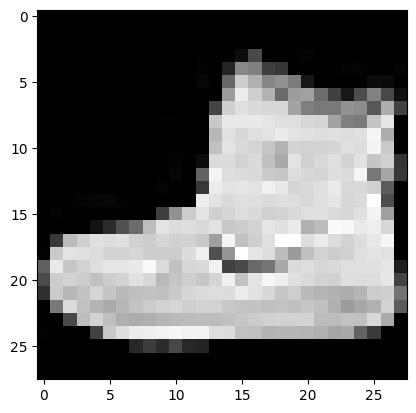

In [35]:
plt.imshow(image.squeeze(),cmap='gray')
print(image.shape)

In [36]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [37]:
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Summary
In order to determine the in_features of self.classifier layer we need perform steps :

* Print out corresponding shapes of layers in the forward function.
* Run model instance with a dummy tensor matching the shape of the test data (here 'image').
* Let the output shape of conv_block_2 be torch.Size([1, 10, 7, 7]), then the this output will be passed on to the flatten layer of self.classifier layer --> outputs to 10`*`7`*`7.

Thus shape of in_features will be:
10`*`7`*`7 --> (hidden_features)`*`7`*`7

# Stepping through nn.Conv2d()

In [38]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [39]:
torch.manual_seed(42)
# Create a sinlge conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=(3, 3),
                       stride=1,
                       padding=0)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 10, 62, 62])

# Stepping through nn.MaxPool2d()

In [40]:
test_image.shape, test_image.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [41]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [42]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"\nRandom tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n {max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")


Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
 tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


# Training & Testing CNN

In [43]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.59354 | Train acc: 78.38%
Test loss: 0.40142 | Test acc: 85.91%

Epoch: 1
-------
Train loss: 0.36355 | Train acc: 86.85%
Test loss: 0.37765 | Test acc: 85.86%

Epoch: 2
-------
Train loss: 0.32499 | Train acc: 88.22%
Test loss: 0.32924 | Test acc: 87.74%

Epoch: 3
-------
Train loss: 0.30161 | Train acc: 88.92%
Test loss: 0.32730 | Test acc: 88.26%

Epoch: 4
-------
Train loss: 0.28749 | Train acc: 89.43%
Test loss: 0.31385 | Test acc: 89.09%

Train time on cuda: 62.902 seconds


In [45]:
model_2_results = eval_model(
     model=model_2,
     data_loader=test_dataloader,
     loss_fn=loss_fn,
     accuracy_fn=accuracy_fn,
     device=device
)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31385111808776855,
 'model_acc': 89.08746006389777}

In [46]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.468343,83.186901
1,FashionMNISTModelV1,0.652765,75.948482
2,FashionMNISTModelV2,0.313851,89.087460


In [47]:
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.468343,83.186901,59.944583
1,FashionMNISTModelV1,0.652765,75.948482,53.708409
2,FashionMNISTModelV2,0.313851,89.087460,62.902209


Text(0, 0.5, 'model')

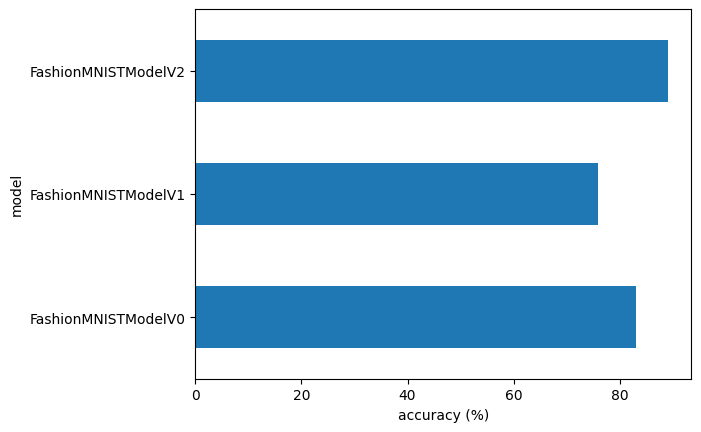

In [48]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

# Model Evaluation

In [49]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [50]:
img, label = test_data[0][:10]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [51]:
# to get 9 random samples with their labels for model evaluation.
import random
#random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

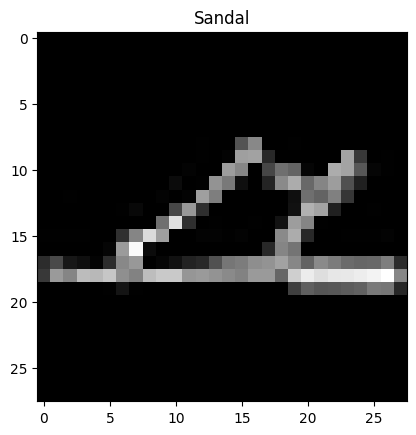

In [52]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_name[test_labels[0]])

In [53]:
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:3]

tensor([[4.1566e-05, 6.5006e-09, 1.7980e-06, 7.5011e-06, 5.6798e-08, 9.9992e-01,
         4.2772e-06, 1.7799e-05, 7.5510e-06, 3.7109e-06],
        [9.9743e-07, 1.1405e-07, 1.4978e-07, 2.6430e-05, 8.8843e-07, 5.4493e-03,
         3.4874e-07, 7.9603e-01, 9.2298e-05, 1.9840e-01],
        [2.0448e-06, 2.1309e-08, 1.3482e-07, 3.3848e-08, 4.2329e-08, 9.9997e-01,
         5.6794e-08, 1.2469e-05, 1.1333e-05, 1.3087e-06]])

In [54]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 7, 5, 3, 2, 1, 6, 9, 1])

In [55]:
test_labels

[5, 9, 5, 3, 2, 1, 2, 9, 1]

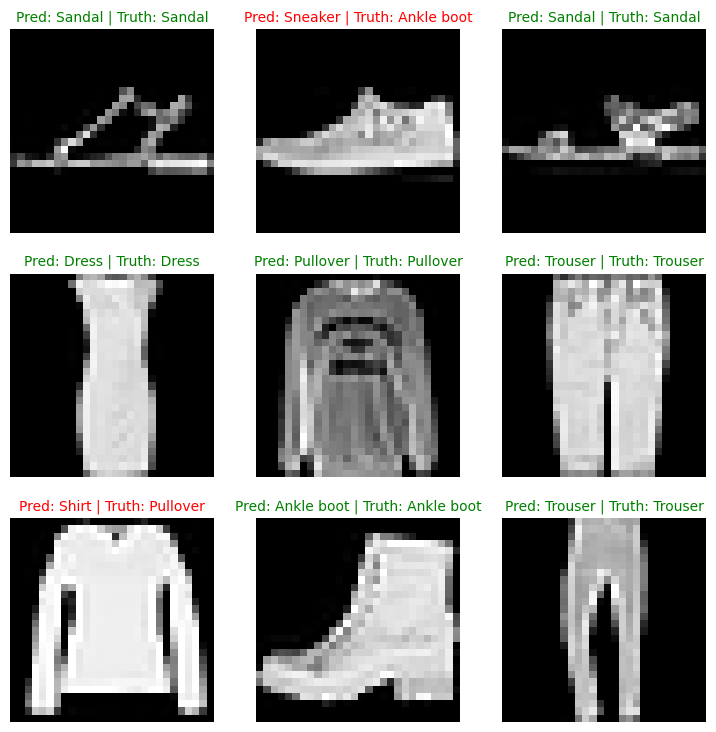

In [56]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_name[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_name[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

# Making a confusion matrix

In [57]:
# Import tqdm.auto
from tqdm.auto import tqdm


# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 0])

In [58]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1
mlxtend version: 0.23.1


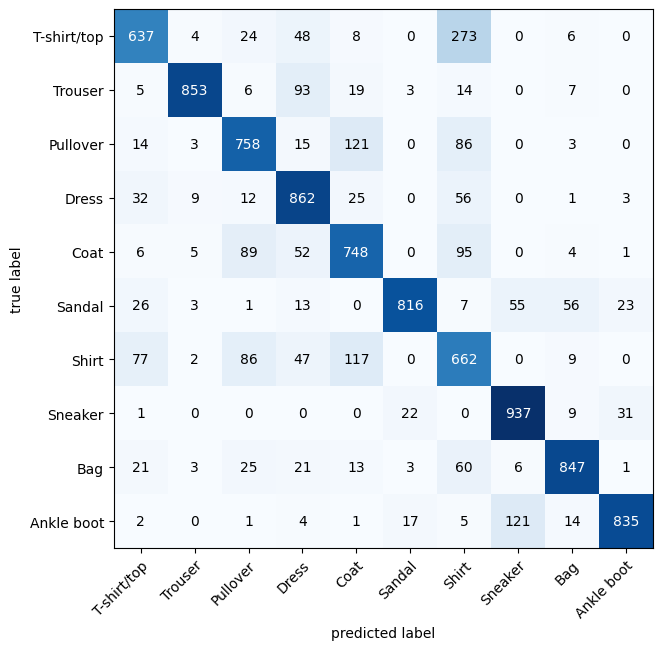

In [61]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass",num_classes=len(class_name))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_name,
    figsize=(10, 7))

In [62]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [64]:
# Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_name))

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [65]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31385111808776855,
 'model_acc': 89.08746006389777}

In [66]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31385111808776855,
 'model_acc': 89.08746006389777}

In [67]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-02)

tensor(True)